# Basic Imports

In [1]:
from util import *

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


# Create teacher and student model

Both:

In [25]:
teacher, sampler_teacher, student, sampler_student = create_models(config_path, model_path, student=True)

Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


Only the student or teacher:

(setting student=False will only return a single model)

In [2]:
teacher, sampler_teacher = create_models(config_path, model_path, student=False)
# student, sampler_student = create_models(config_path, model_path, student=False)

Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


## Generating WITHOUT intermediates saved

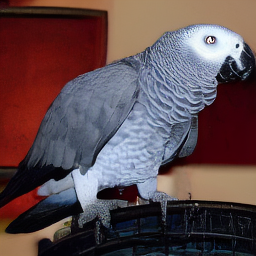

In [24]:
img, x_T_copy, class_prompt, intermediates  = generate(teacher, sampler_teacher, steps=128, scale=3, keep_intermediates=False)
img

# Generating WITH intermediates saved

In [7]:
intermediates, starting_noise, class_prompt = return_intermediates_for_student(teacher, sampler_teacher, steps=250)

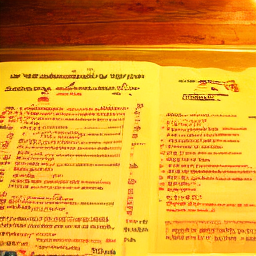

In [14]:
latent_to_img(teacher, intermediates[125])

# Creating a dataset

In [4]:
dataset_path = f"{cwd}/data/pre_generated/teacher_128/"
dataset_name = "teacher_128.pt"
make_dataset(teacher, sampler_teacher, 500, 128, dataset_path, dataset_name)

100%|██████████| 500/500 [1:27:11<00:00, 10.46s/it]


# Training student from teacher directly

100%|██████████| 3/3 [00:17<00:00,  5.69s/it, loss=0.00538]


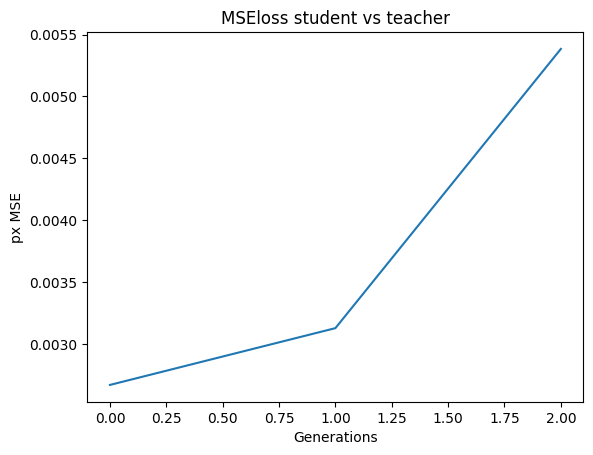

In [28]:
teacher_train_student(teacher, sampler_teacher, student, sampler_student, steps=20, generations=3, lr=0.00000001, early_stop=True)

Extra, quick comparison:

In [5]:
images = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[8, 10, 12])
images

NameError: name 'student' is not defined

# Train student from pre-generated teacher dataset

In [2]:
dataset_path = f"{cwd}/data/pre_generated/teacher_128/4_teacher_128.pt"
dataset = torch.load(dataset_path)

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


100%|██████████| 4/4 [00:58<00:00, 14.66s/it, loss=0.000229]


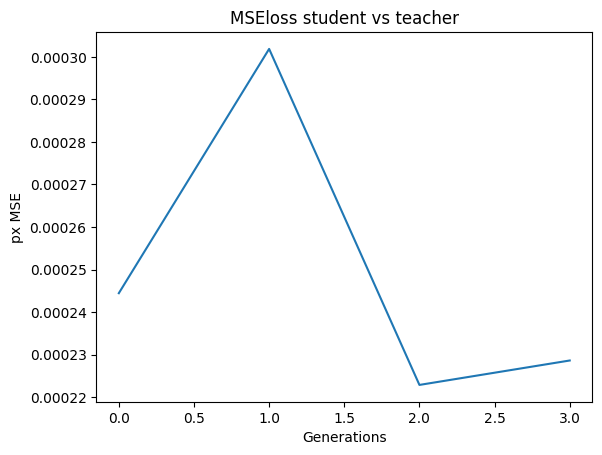

In [3]:
train_student_from_dataset(student, sampler_student, dataset, 64, lr=0.00000001, early_stop=False)


# Direct Comparison

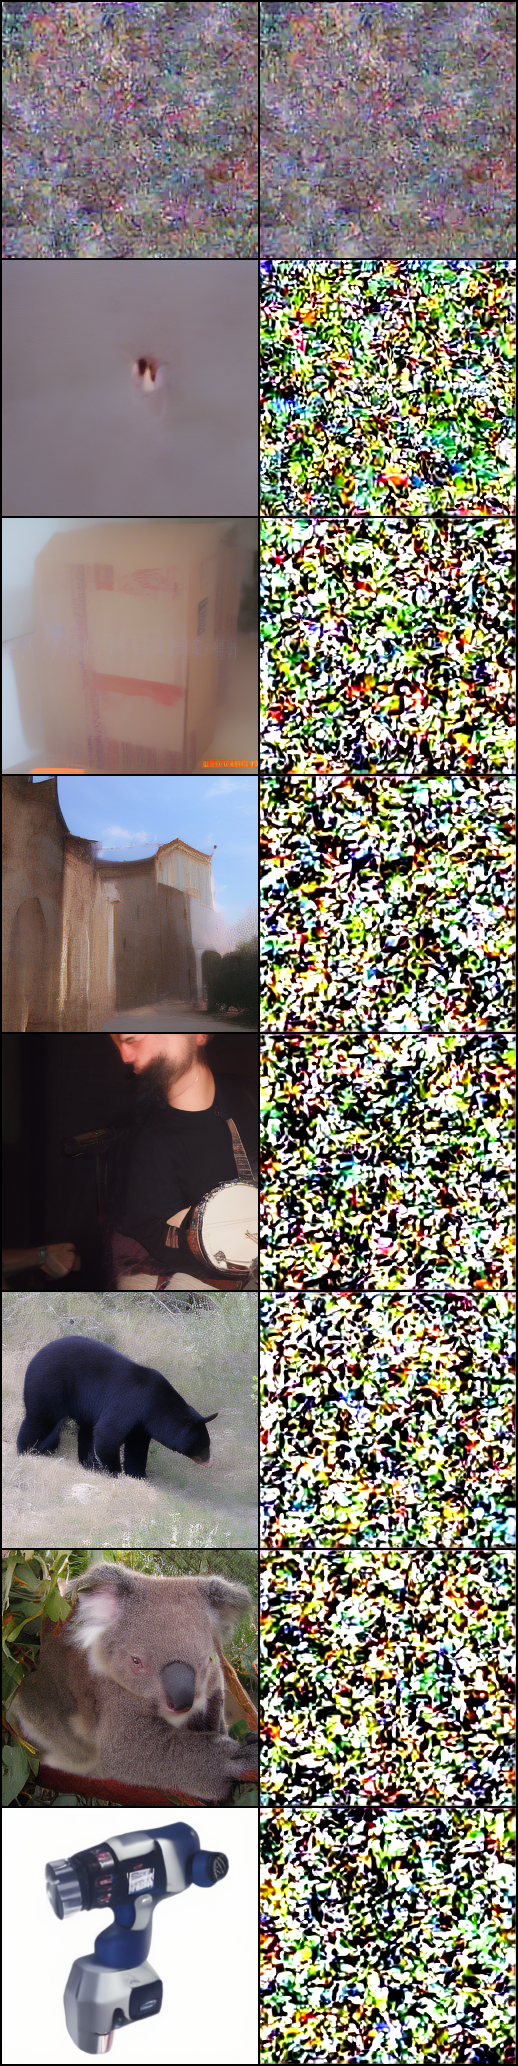

In [17]:
images = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 6, 8, 10, 12, 14])
images